In [1]:
using Pkg
Pkg.activate(normpath(joinpath(@__DIR__, "..")))

  Activating environment at `~/FiB/reco_code/NReco/Project.toml`


In [2]:
using ATools
using Configurations
using DataFrames
using Distributions
using Glob
using HDF5
using Logging
using Plots
using Statistics
using StatsBase

┌ Info: Precompiling ATools [f146b9ee-cb39-4cb9-873f-768aeedb20d7]
└ @ Base loading.jl:1342


In [3]:
@option struct CalConfig
  input_dir::String
  conf_dir ::String
  plot_dir ::String
  qmin     ::Float32
  qmax     ::Float32
end

In [4]:
## Change the configuration .toml to change the input and cuts.
config_file = "../config/cal_n5-30mm.toml"
conf        = from_toml(CalConfig, config_file)

CalConfig("../../data/", "h5test-n5-dz1m-LXe30mm-noQrz-4/", "plot_dir", 1900.0f0, 2200.0f0)

In [5]:
## Basic setup: Variables shouold be adjusted for each relevant run
# normalisation: number of decays simulated, should be saved somewhere!
# rmin         : Ring minimum r
# rmax         : Ring maximum r
# in_dir       : directory where the output folders of makenema.jl are.
# config       : subdirectory for input/output
# plot_dir     : base directory for plots
in_dir    = conf.input_dir
config    = conf.conf_dir
plot_dir  = conf.plot_dir
if !isdir(plot_dir)
  mkdir(plot_dir)
end
in_path   = joinpath(in_dir, config)
plot_path = joinpath(plot_dir, config)
if !isdir(plot_path)
  mkdir(plot_path)
end

In [6]:
in_path

"../../data/h5test-n5-dz1m-LXe30mm-noQrz-4/"

In [7]:
rmin   = typemax(Float64)
rmax   = typemin(Float64)
norm   = zero(Int64)
df_vec = DataFrame[]
for fn in glob("*.h5", in_path)
  s_conf = h5open(fn) do h5in
    sim_conf = readh5_dset(h5in, "configuration", "RunConfiguration")[1]
    
    push!(df_vec, readh5_todf(h5in, "selected_events", "EventParameters"))
    return sim_conf
  end
  norm    += s_conf.NEvent
  rmin     = s_conf.Rmin < rmin ? s_conf.Rmin : rmin
  rmax     = s_conf.Rmax > rmax ? s_conf.Rmax : rmax
end
ndf = vcat(df_vec...)
println(norm, " simulated events, ", nrow(ndf), " with two interactions: ", 100 * nrow(ndf) / norm, "%")

1500000 simulated events, 354423 with two interactions: 23.6282%


# Check on total charge

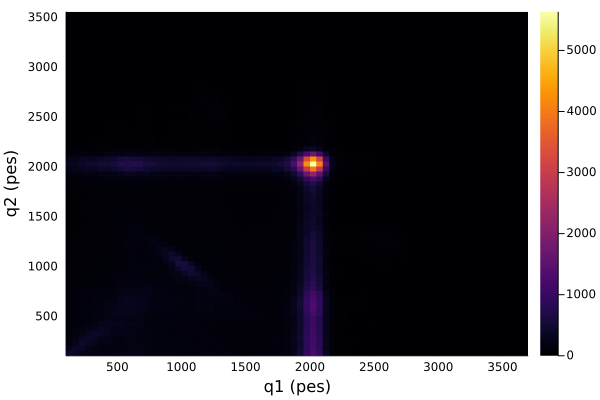

In [8]:
q1min, q1max = (minimum(ndf.q1), maximum(ndf.q1))
q2min, q2max = (minimum(ndf.q2), maximum(ndf.q2))
_, pq1q2 = hist2d(ndf.q1, ndf.q2, 100, "q1 (pes)", "q2 (pes)", q1min, q1max, q2min, q2max)
plot(pq1q2)

In [9]:
interval = ATools.range_bound(conf.qmin, conf.qmax, ATools.OpenBound)
ndfq = filter(x -> broadcast(interval, x.q1) .& broadcast(interval, x.q2), ndf)
println("Photoelectric charge cut leaves ", nrow(ndfq) / nrow(ndf), " of the double interactions, ", nrow(ndfq) / norm, "% of simulated events.")

Photoelectric charge cut leaves 0.16223552083245163 of the double interactions, 0.03833333333333333% of simulated events.


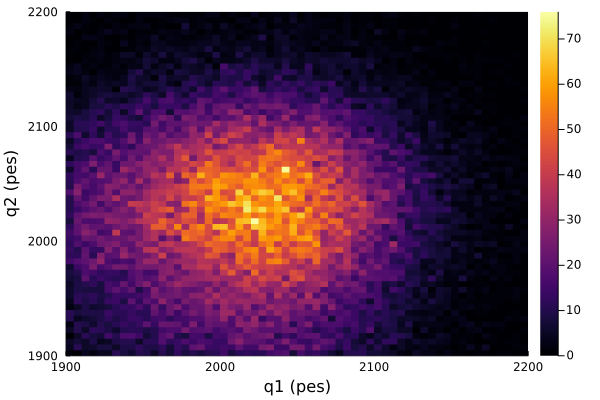

In [10]:
_, pq1q2_f = hist2d(ndfq.q1, ndfq.q2, 100, "q1 (pes)", "q2 (pes)", q1min, q1max, q2min, q2max)
plot(pq1q2_f)

# Combine the two hemispheres for calibration

In [11]:
function combined_std(df::DataFrame, stdz::Symbol, stdphi::Symbol)
  sqrt.(df[!, stdz].^2 + (rmax .* df[!, stdphi]).^2)
end

combined_std (generic function with 1 method)

In [12]:
ring_df = DataFrame(:r => vcat(ndfq.r1, ndfq.r2), :nsipm => vcat(ndfq.nsipm1, ndfq.nsipm2), :zstd => vcat(ndfq.zstd1, ndfq.zstd2), :phistd => vcat(ndfq.phistd1, ndfq.phistd2))
## Add a column with the combination of the two axes
ring_df[!, "stdrad"] = combined_std(ring_df, :zstd, :phistd);

## Correlations between the size of the area of charge seen and the interaction radius

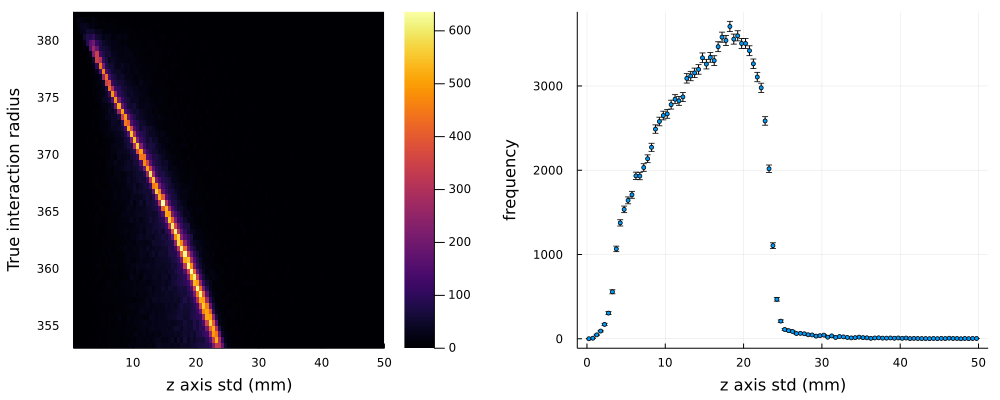

In [13]:
_, pzr = hist2d(ring_df.zstd, ring_df.r, 100, "z axis std (mm)", "True interaction radius", 0.0f0, 50.0f0, 350.0f0, 400.0f0)
hz, pz  = hist1d(ring_df.zstd, "z axis std (mm)", 100, 0.0f0, 50.0f0)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pzr, pz, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [14]:
zmax, _ = findmax(hz.weights)
useful_bins = findall(x -> x >= 0.1 * zmax, hz.weights)
nbinszpr = useful_bins[end] - useful_bins[1] + 1
minzpr   = edges(hz)[useful_bins[1]]
maxzpr   = edges(hz)[useful_bins[end] + 1]

24.5f0

proportion of selected events in fit range: 0.9831826086956522
Fit parameters: a = 384.4533199817602, b = -1.2909771000996078
Fit errors: a = 0.09488151149915838 b = 0.006289681543678996


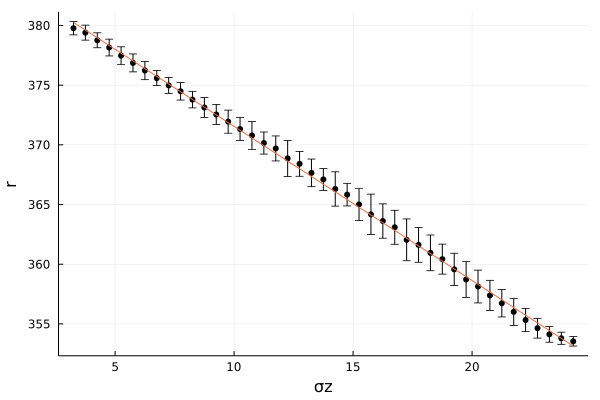

In [15]:
mask_std = (ring_df.zstd .>= minzpr) .& (ring_df.zstd .< maxzpr)
println("proportion of selected events in fit range: ", count(mask_std) / nrow(ring_df))
fzr, pzr = fit_profile(ring_df[mask_std, :zstd], ring_df[mask_std, :r], "σz", "r", "pol1", nbinszpr; ymin=rmin, ymax=rmax, min_proportion=0.1)
fpars = fzr.fitpar
fstds = fzr.fitstd
println("Fit parameters: a = ", fpars[1], ", b = ", fpars[2])
println("Fit errors: a = ", fstds[1], " b = ", fstds[2])
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pzr)

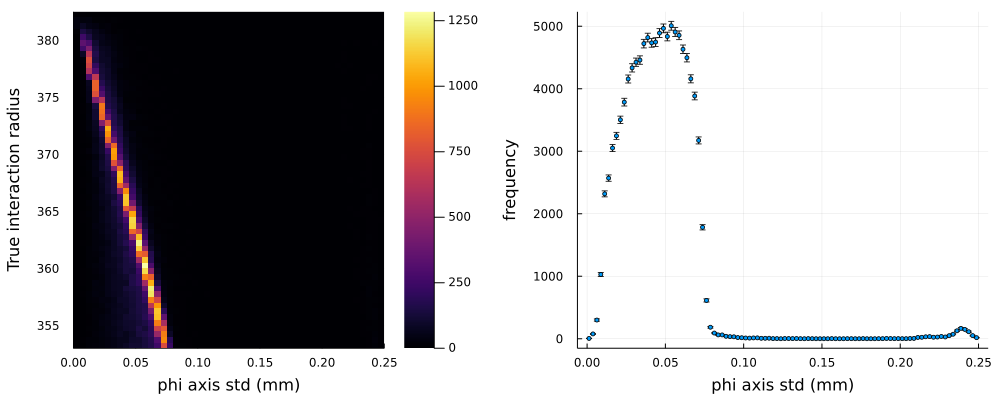

In [16]:
_, ppr = hist2d(ring_df.phistd, ring_df.r, 100, "phi axis std (mm)", "True interaction radius", 0.0f0, 0.25f0, 350.0f0, 400.0f0)
hp, pp  = hist1d(ring_df.phistd, "phi axis std (mm)", 100, 0.0f0, 0.25f0)
## Need to move some funcitons from ANema to either ATools or NReco
plot(ppr, pp, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [17]:
pmax, _ = findmax(hp.weights)
useful_bins = findall(x -> x >= 0.1 * pmax, hp.weights)
nbinsppr = useful_bins[end] - useful_bins[1] + 1
minppr   = edges(hp)[useful_bins[1]]
maxppr   = edges(hp)[useful_bins[end] + 1]

0.0775f0

proportion of selected events in fit range: 0.9400173913043478
Fit parameters: a = 383.0359387203221, b = -398.9492106424636
Fit errors: a = 0.13343715155383457 b = 2.8358004523870624


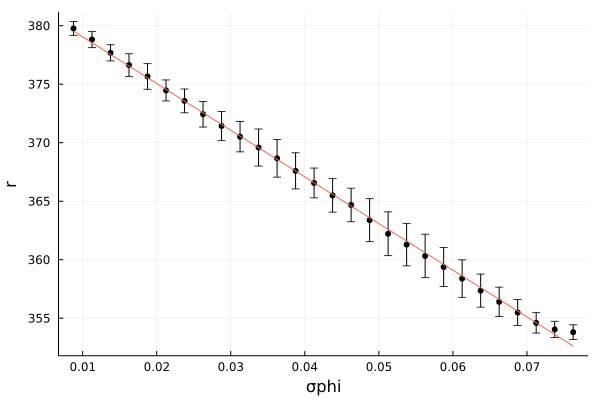

In [18]:
mask_std = (ring_df.phistd .>= minppr) .& (ring_df.phistd .< maxppr)
println("proportion of selected events in fit range: ", count(mask_std) / nrow(ring_df))
fpr, ppr = fit_profile(ring_df[mask_std, :phistd], ring_df[mask_std, :r], "σphi", "r", "pol1", nbinsppr; ymin=rmin, ymax=rmax, min_proportion=0.1)
fpars = fpr.fitpar
fstds = fpr.fitstd
println("Fit parameters: a = ", fpars[1], ", b = ", fpars[2])
println("Fit errors: a = ", fstds[1], " b = ", fstds[2])
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(ppr)

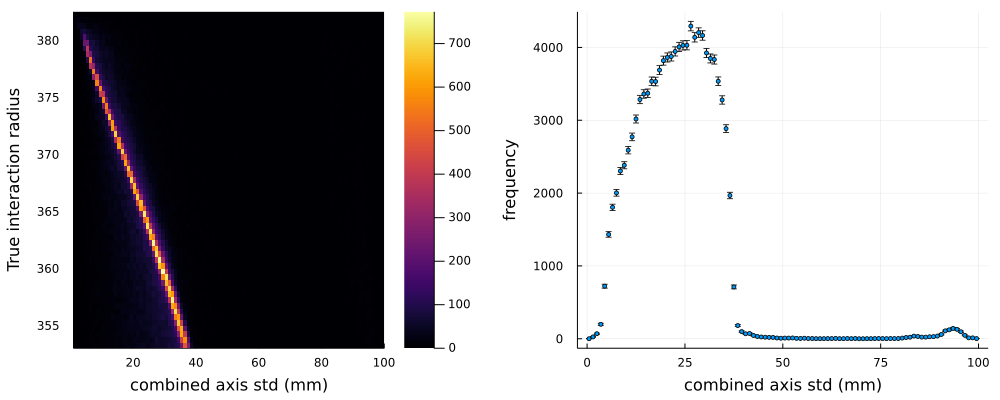

In [19]:
_, pcr = hist2d(ring_df.stdrad, ring_df.r, 100, "combined axis std (mm)", "True interaction radius", 0.0f0, 100.0f0, 350.0f0, 400.0f0)
hc, pc  = hist1d(ring_df.stdrad, "combined axis std (mm)", 100, 0.0f0, 100.0f0)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pcr, pc, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [20]:
cmax, _ = findmax(hc.weights)
useful_bins = findall(x -> x >= 0.1 * cmax, hc.weights)
nbinscpr = useful_bins[end] - useful_bins[1] + 1
mincpr   = edges(hc)[useful_bins[1]]
maxcpr   = edges(hc)[useful_bins[end] + 1]

38.0f0

proportion of selected events in fit range: 0.9404347826086956
Fit parameters: a = 383.79073977757287, b = -0.8159760655982438
Fit errors: a = 0.06947034222606088 b = 0.0029972313014907485


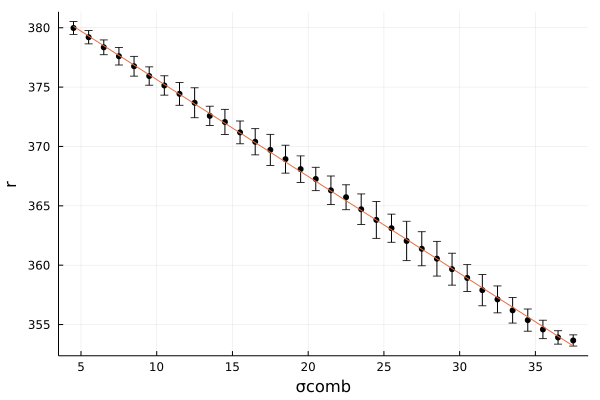

In [21]:
mask_std = (ring_df.stdrad .>= mincpr) .& (ring_df.stdrad .< maxcpr)
println("proportion of selected events in fit range: ", count(mask_std) / nrow(ring_df))
fcr, pcr = fit_profile(ring_df[mask_std, :stdrad], ring_df[mask_std, :r], "σcomb", "r", "pol1", nbinscpr; ymin=rmin, ymax=rmax, min_proportion=0.1)
fpars = fcr.fitpar
fstds = fcr.fitstd
println("Fit parameters: a = ", fpars[1], ", b = ", fpars[2])
println("Fit errors: a = ", fstds[1], " b = ", fstds[2])
#ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pcr)

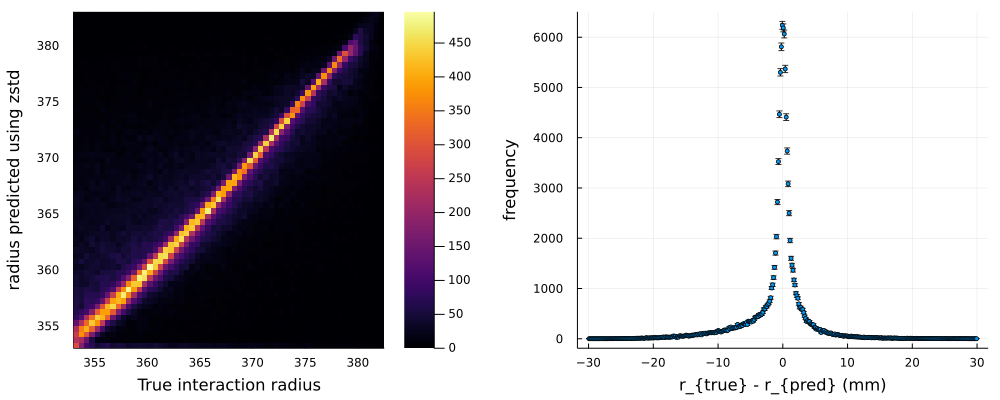

In [46]:
zpredr = ATools.predict_interaction_radius(fzr.g, rmin, rmax)(ring_df.zstd)
_, pRzres = hist2d(ring_df.r, Float32.(zpredr), 100, "True interaction radius", "radius predicted using zstd", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hzres, pzres  = hist1d(Float32.(ring_df.r - zpredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRzres, pzres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

Fit result 0.0247627292593179, 0.6085810167713427, 3.5565690026223575


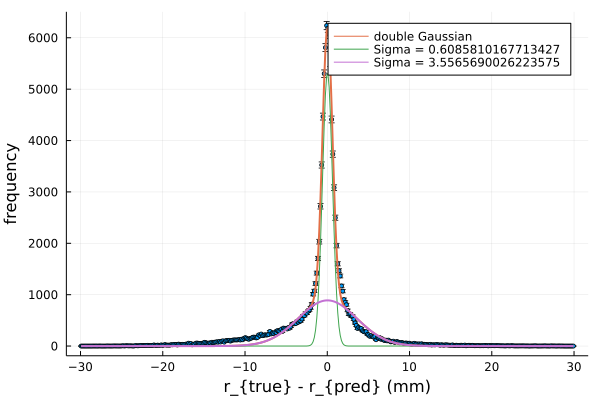

In [51]:
x_vals = ATools.centers(hzres)
imax, xmax, _ = ATools.find_max_xy(x_vals, hzres.weights)
mean_val      = mean(x_vals, FrequencyWeights(hzres.weights))
sigma_centre = std(x_vals[imax-5:imax+5], FrequencyWeights(hzres.weights[imax-5:imax+5]), corrected=true)
sigma_all    = std(x_vals, FrequencyWeights(hzres.weights), corrected=true)
## norm first G, mean, sigma first G, norm second G, sigma second G
lb = [0.0, mean_val - 100, 0.0, 0.0, 0.0]
ub = [sum(hzres.weights) * 100, mean_val + 100, sigma_centre * 100, sum(hzres.weights) * 100, sigma_all * 100]
p0 = [sum(hzres.weights[imax-5:imax+5]), xmax, sigma_centre, sum(hzres.weights), sigma_all]
coeffs = ATools.cfit(ATools.gausscm, Float64.(x_vals), Float64.(hzres.weights), p0, lb, ub)

fitmeanz = coeffs[2]
sigma1   = coeffs[3]
sigma2   = coeffs[5]
println("Fit result ", fitmeanz, ", ", sigma1, ", ", sigma2)
pzres = plot!(pzres, x_vals, ATools.gausscm(x_vals, coeffs), label="double Gaussian", lw=2, fmt=:png)
pzres = plot!(pzres, x_vals, ATools.gausg(coeffs[2], coeffs[3], coeffs[1])(x_vals), label="Sigma = $sigma1", lw=1, fmt=:png)
pzres = plot!(pzres, x_vals, ATools.gausg(coeffs[2], coeffs[5], coeffs[4])(x_vals), label="Sigma = $sigma2", lw=2, fmt=:png)
plot(pzres)

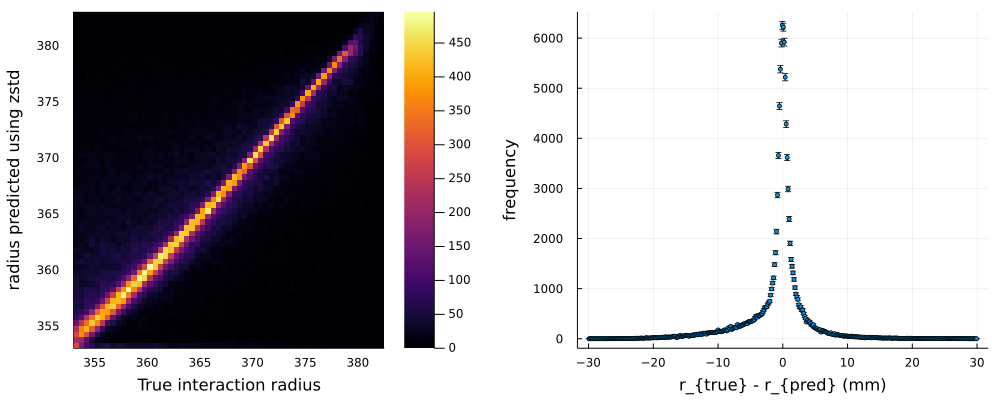

In [54]:
zpredr = ATools.predict_interaction_radius(fzr.g, rmin, rmax, fitmeanz)(ring_df.zstd)
_, pRzres = hist2d(ring_df.r, Float32.(zpredr), 100, "True interaction radius", "radius predicted using zstd", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hzres, pzres  = hist1d(Float32.(ring_df.r - zpredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRzres, pzres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

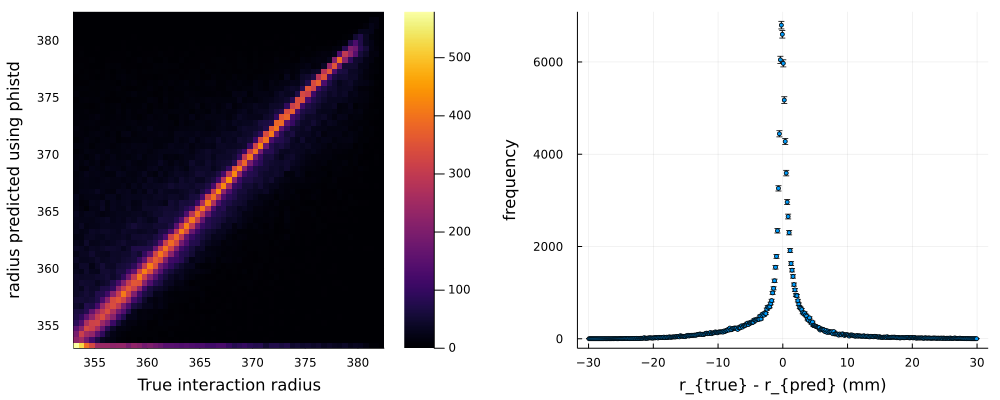

In [56]:
ppredr = ATools.predict_interaction_radius(fpr.g, rmin, rmax)(ring_df.phistd)
_, pRpres = hist2d(ring_df.r, Float32.(ppredr), 100, "True interaction radius", "radius predicted using phistd", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hpres, ppres  = hist1d(Float32.(ring_df.r - ppredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRpres, ppres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

Fit result -0.061038636901431895, 0.5064279769986776, 3.331562976315451


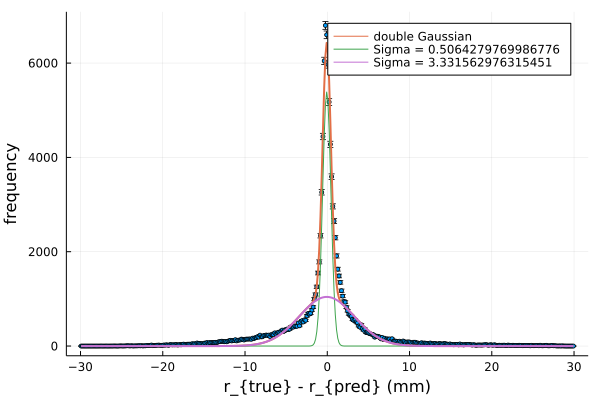

In [58]:
x_vals = ATools.centers(hpres)
imax, xmax, _ = ATools.find_max_xy(x_vals, hpres.weights)
mean_val      = mean(x_vals, FrequencyWeights(hpres.weights))
sigma_centre = std(x_vals[imax-5:imax+5], FrequencyWeights(hpres.weights[imax-5:imax+5]), corrected=true)
sigma_all    = std(x_vals, FrequencyWeights(hpres.weights), corrected=true)
## norm first G, mean, sigma first G, norm second G, sigma second G
lb = [0.0, mean_val - 100, 0.0, 0.0, 0.0]
ub = [sum(hpres.weights) * 100, mean_val + 100, sigma_centre * 100, sum(hzres.weights) * 100, sigma_all * 100]
p0 = [sum(hpres.weights[imax-5:imax+5]), xmax, sigma_centre, sum(hpres.weights), sigma_all]
coeffs = ATools.cfit(ATools.gausscm, Float64.(x_vals), Float64.(hpres.weights), p0, lb, ub)

fitmeanp = coeffs[2]
sigma1   = coeffs[3]
sigma2   = coeffs[5]
println("Fit result ", fitmeanp, ", ", sigma1, ", ", sigma2)
ppres = plot!(ppres, x_vals, ATools.gausscm(x_vals, coeffs), label="double Gaussian", lw=2, fmt=:png)
ppres = plot!(ppres, x_vals, ATools.gausg(coeffs[2], coeffs[3], coeffs[1])(x_vals), label="Sigma = $sigma1", lw=1, fmt=:png)
ppres = plot!(ppres, x_vals, ATools.gausg(coeffs[2], coeffs[5], coeffs[4])(x_vals), label="Sigma = $sigma2", lw=2, fmt=:png)
plot(ppres)

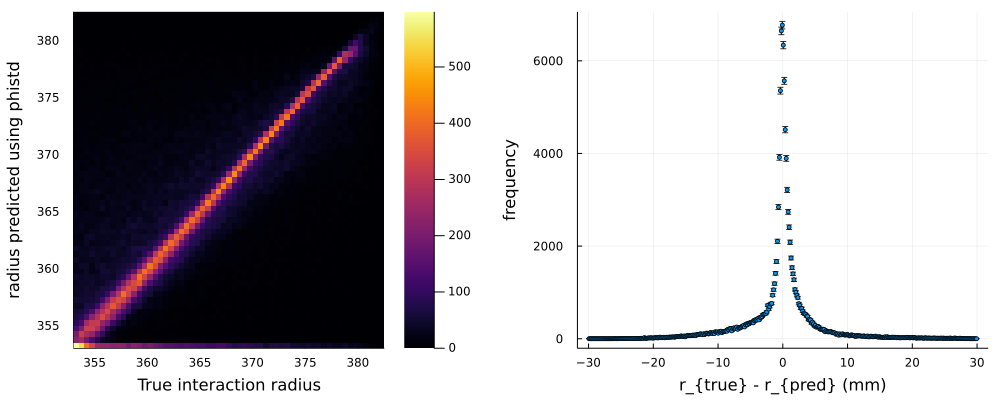

In [61]:
ppredr = ATools.predict_interaction_radius(fpr.g, rmin, rmax, fitmeanp)(ring_df.phistd)
_, pRpres = hist2d(ring_df.r, Float32.(ppredr), 100, "True interaction radius", "radius predicted using phistd", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hpres, ppres  = hist1d(Float32.(ring_df.r - ppredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRpres, ppres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

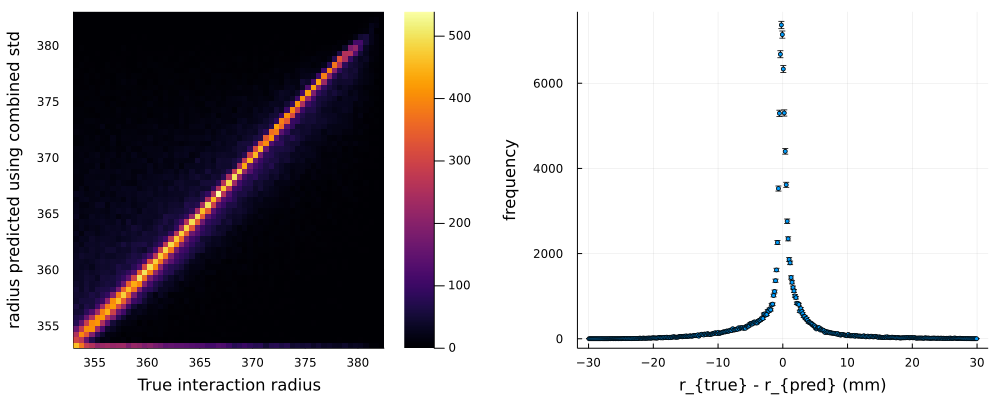

In [63]:
cpredr = ATools.predict_interaction_radius(fcr.g, rmin, rmax)(ring_df.stdrad)
_, pRcres = hist2d(ring_df.r, Float32.(cpredr), 100, "True interaction radius", "radius predicted using combined std", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hcres, pcres  = hist1d(Float32.(ring_df.r - cpredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRcres, pcres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

Fit result -0.09869266437988942, 0.46461207251630027, 3.4072490369194046


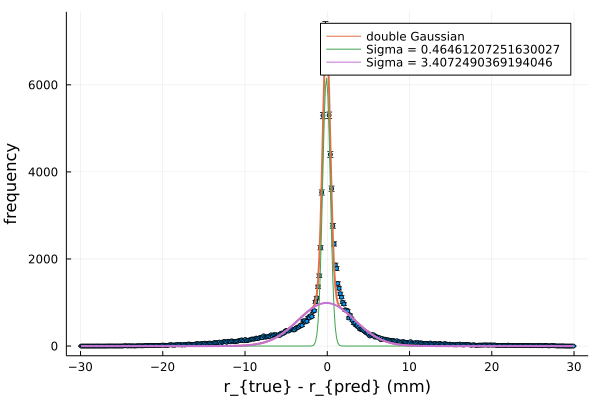

In [65]:
x_vals = ATools.centers(hcres)
imax, xmax, _ = ATools.find_max_xy(x_vals, hcres.weights)
mean_val      = mean(x_vals, FrequencyWeights(hcres.weights))
sigma_centre = std(x_vals[imax-5:imax+5], FrequencyWeights(hcres.weights[imax-5:imax+5]), corrected=true)
sigma_all    = std(x_vals, FrequencyWeights(hcres.weights), corrected=true)
## norm first G, mean, sigma first G, norm second G, sigma second G
lb = [0.0, mean_val - 100, 0.0, 0.0, 0.0]
ub = [sum(hcres.weights) * 100, mean_val + 100, sigma_centre * 100, sum(hcres.weights) * 100, sigma_all * 100]
p0 = [sum(hcres.weights[imax-5:imax+5]), xmax, sigma_centre, sum(hcres.weights), sigma_all]
coeffs = ATools.cfit(ATools.gausscm, Float64.(x_vals), Float64.(hcres.weights), p0, lb, ub)

fitmeanc = coeffs[2]
sigma1   = coeffs[3]
sigma2   = coeffs[5]
println("Fit result ", fitmeanc, ", ", sigma1, ", ", sigma2)
pcres = plot!(pcres, x_vals, ATools.gausscm(x_vals, coeffs), label="double Gaussian", lw=2, fmt=:png)
pcres = plot!(pcres, x_vals, ATools.gausg(coeffs[2], coeffs[3], coeffs[1])(x_vals), label="Sigma = $sigma1", lw=1, fmt=:png)
pcres = plot!(pcres, x_vals, ATools.gausg(coeffs[2], coeffs[5], coeffs[4])(x_vals), label="Sigma = $sigma2", lw=2, fmt=:png)
plot(pcres)

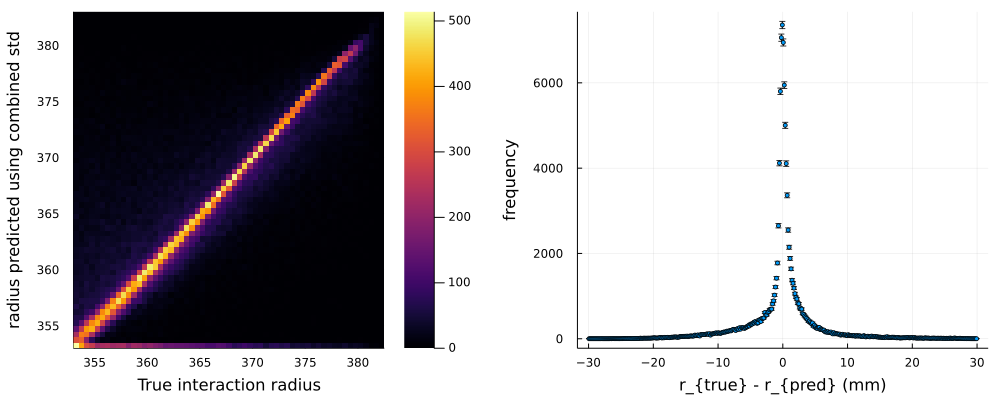

In [68]:
cpredr = ATools.predict_interaction_radius(fcr.g, rmin, rmax, fitmeanc)(ring_df.stdrad)
_, pRcres = hist2d(ring_df.r, Float32.(cpredr), 100, "True interaction radius", "radius predicted using combined std", rmin - 2.0f0, rmax + 2.0f0, rmin - 2.0f0, rmax + 2.0f0)
hcres, pcres  = hist1d(Float32.(ring_df.r - cpredr), "r_{true} - r_{pred} (mm)", 400, rmin - rmax, rmax - rmin, legend=true)
## Need to move some funcitons from ANema to either ATools or NReco
plot(pRcres, pcres, layout= (1, 2), legend=false, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

## Combination slightly better predictor, use it in this version

In [70]:
rpred = ATools.predict_interaction_radius(fcr.g, rmin, rmax, fitmeanc)
ndfq[!, :r1x] = rpred(combined_std(ndfq, :zstd1, :phistd1))
ndfq[!, :r2x] = rpred(combined_std(ndfq, :zstd2, :phistd2));

In [71]:
xp1, yp1, zp1 = ATools.radial_correction(ndfq.xr1, ndfq.yr1, ndfq.zr1, ndfq.r1x);
xp2, yp2, zp2 = ATools.radial_correction(ndfq.xr2, ndfq.yr2, ndfq.zr2, ndfq.r2x);

In [75]:
fg, px1 = fitg1(ndfq.xt1 - xp1, "xt-xp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
println(" σx1 = ", fg.std[1], " mm")
fg, py1 = fitg1(ndfq.yt1 - yp1, "yt-yp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
println(" σy1 = ", fg.std[1], " mm")
fg, pz1 = fitg1(Float64.(ndfq.zt1 - zp1), "zt-zp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
println(" σz1 = ", fg.std[1], " mm")

 σx1 = 0.6759440129635697 mm
 σy1 = 0.7114769638932164 mm
 σz1 = 0.639197683105687 mm


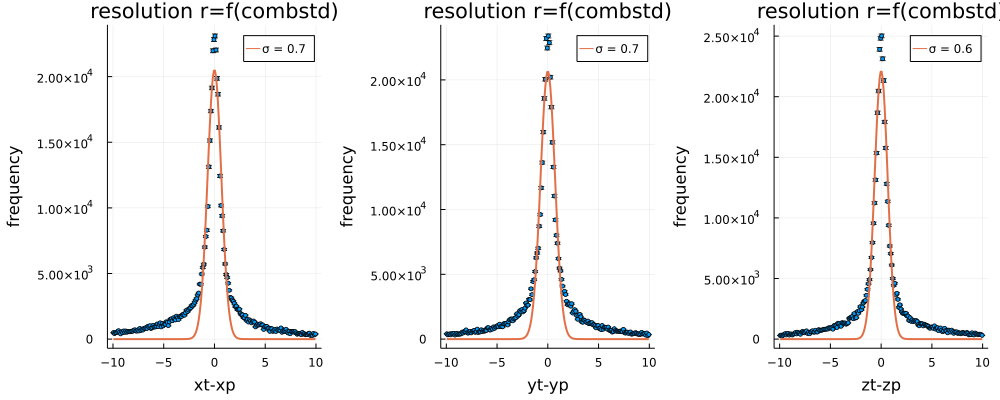

In [76]:
plot(px1, py1, pz1, layout= (1, 3), title="resolution r=f(combstd)", legend=true, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

x-x(rcomb) σ1 = 3.320129419099172 σ2 = 0.49819511324579935
y-y(rcomb) σ1 = 2.9493954984144395 σ2 = 0.5078728464469683
z-z(rcomb) σ1 = 3.121951258092528 σ2 = 0.48846671739319186


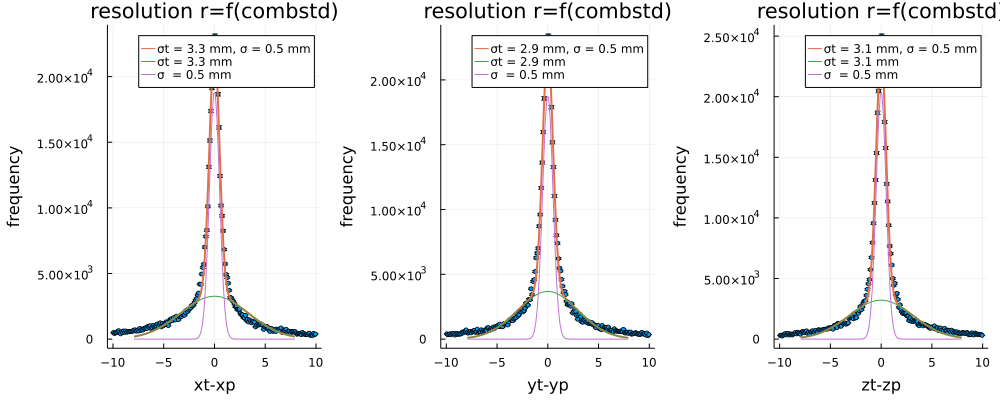

In [78]:
fg, px = fitg2(ndfq.xt1 - xp1, "xt-xp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
println("x-x(rcomb) σ1 = ", fg.std[1], " σ2 = ", fg.std[2])

fg, py = fitg2(ndfq.yt1 - yp1, "yt-yp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
println("y-y(rcomb) σ1 = ", fg.std[1], " σ2 = ", fg.std[2])

fg, pz = fitg2(Float64.(ndfq.zt1 - zp1), "zt-zp", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
println("z-z(rcomb) σ1 = ", fg.std[1], " σ2 = ", fg.std[2])
plots_res = plot(px, py, pz, layout= (1, 3), title="resolution r=f(combstd)", legend=true, fmt = :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [79]:

png(plots_res, joinpath(plot_path, "xyz_interaction_resolution"))

In [80]:
## Get the true interaction radius (Why not saved?)
transform!(ndfq, [:xt1, :yt1] => ((x, y) -> sqrt.(x.^2 + y.^2)) => :rt1, [:xt2, :yt2] => ((x, y) -> sqrt.(x.^2 + y.^2)) => :rt2);
units_ndfq = ATools.set_units(ndfq);

first photoelectron, position reco: FWHM = 309.11163731608093, FWHM2 = 48.20141763681985


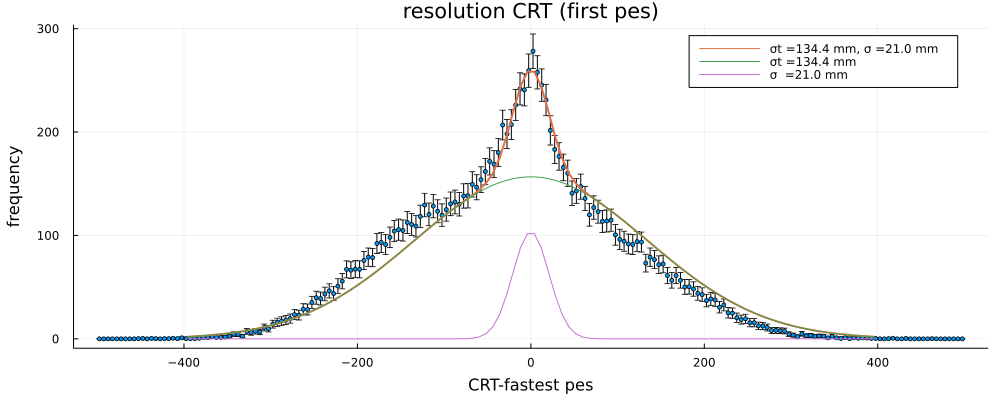

In [81]:
dt = ATools.CRT(units_ndfq, [:t1, :t2], [:rt1, :rt2], rmax)
fg,p = fitg2(dt, "CRT-fastest pes", 200, -500.0, 500.0, xg1min=-400.0, xg1max=-50.0, xg2min=-50.0,  xg2max =50.0, xgmin =-400.0, xgmax  =400.0)
println("first photoelectron, position reco: FWHM = ", 2.3*fg.std[1], ", FWHM2 = ", 2.3*fg.std[2])
best_crt = plot(p, title="resolution CRT (first pes)", legend=true, fmt= :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [82]:
png(best_crt, joinpath(plot_path, "crt_limit_truth"))

fastest photoelectron, position reco: FWHM = 312.95374634276703


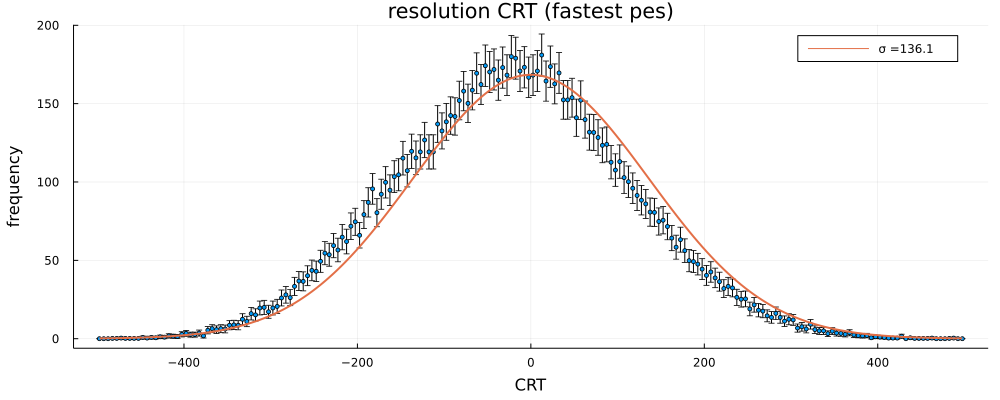

In [83]:
dt = ATools.CRT(units_ndfq, [:tr1, :tr2], [:rt1, :rt2], rmax)
fg, p = fitg1(dt, "CRT", 200, -500.0, 500.0, xgmin=-400.0, xgmax=400.0)
println("fastest photoelectron, position reco: FWHM = ", 2.3*fg.std[1])
fast_crt = plot(p, title="resolution CRT (fastest pes)", legend=true, fmt= :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [84]:
png(fast_crt, joinpath(plot_path, "crt_fastSi_rtruth"))

fastest photoelectron, position reco: FWHM = 295.76621742590015


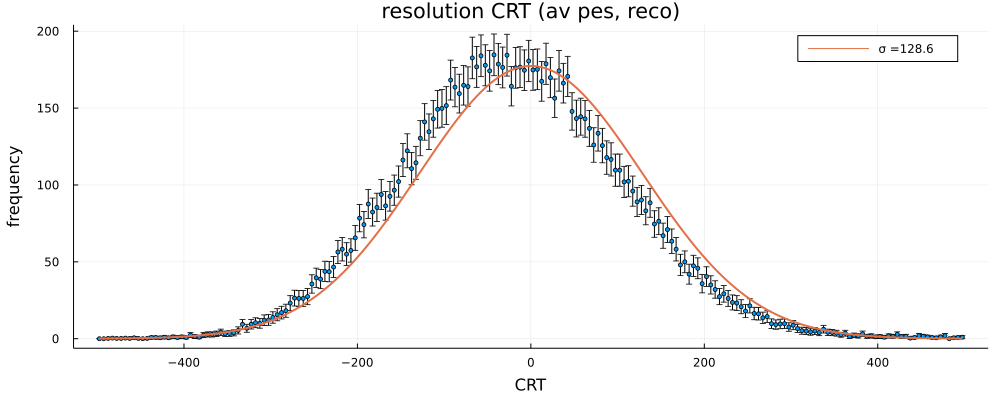

In [85]:
dt = ATools.CRT(units_ndfq, [:ta1, :ta2], [:r1x, :r2x], rmax)
fg, p = fitg1(dt, "CRT", 200, -500.0, 500.0, xgmin=-400.0, xgmax=400.0)
println("fastest photoelectron, position reco: FWHM = ", 2.3*fg.std[1])
reco_crt = plot(p, title="resolution CRT (av pes, reco)", legend=true, fmt= :png, size = (1000, 400), left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)

In [86]:
png(reco_crt, joinpath(plot_path, "crt_avSi_recoR"))